In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import torch
import json
op = os.path

## Helper Functions (skip)

In [104]:
def plot_available_data(dat, ycol, ycolname=None, 
                        xcol='alpha', xcolname="Angle of attack (deg)",
                        label=None, fig=None, style=None, colorbar=False, adapt_ticks=False):
    if fig:
        f = fig
        a = fig.axes[0]
    else:
        f,a = plt.subplots(figsize=(10,8))
    
    label = label if label else ""
    
    Re = dat.Re.drop_duplicates().values
    norm = mpl.colors.Normalize(vmin=Re.min(), vmax=Re.max())
    re_map = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
    
    for r in Re:
        e = dat[dat.Re==r]
        if not e[ycol].hasnans:
            a.plot(e[xcol], e[ycol], style if style else "-+", 
                    label=f"{label}Re {r}", 
                    linewidth=1,
                    color=re_map.to_rgba(r))
    
    a.grid(True)    
    a.set_xlabel(xcolname, size=20)
    a.set_ylabel(ycolname if ycolname else ycol, size=20)
    if colorbar:
        if adapt_ticks:
            keep_tick = np.ones_like(Re) == 1
            keep_tick[1:] = np.diff(Re)/Re[1:] > 0.05
            tks = Re[keep_tick]
        else:
            tks = None
        cb = f.colorbar(re_map, orientation='vertical', ticks=None)
        cb.ax.set_ylabel("Reynold\'s number", size=20)
        cb.ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    else:
        a.legend(fontsize=10)
    a.tick_params(labelsize=15)
    f.tight_layout()
    return f

In [99]:
def compare_dataframes(dataframe_dict, ycol, ycolname=None,
                        xcol='alpha', xcolname="Angle of attack (deg)",
                       fig=None, styles=None, colorbar=False, adapt_ticks=False):
    # Read inputs
    if fig:
        f = fig
        a = fig.axes[0]
    else:
        f,a = plt.subplots(figsize=(10,8))
    
    if not styles:
        st = ["-"]*(len(dataframe_dict) - 1) + ["+"]
        styles = {k:st[i] for i, k in enumerate(dataframe_dict)}
    
    
    # Collect available Re, create colormap
    Re = []
    for dat in dataframe_dict:
        Re += (dataframe_dict[dat].Re.drop_duplicates().tolist())
    Re = np.array(Re)
    norm = mpl.colors.Normalize(vmin=Re.min(), vmax=Re.max())
    re_map = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)

    
    # Plot
    for i, r in enumerate(Re):
        for key, dat in dataframe_dict.items():
            e = dat[dat.Re==r]
            if not e[ycol].hasnans:
                a.plot(e[xcol], e[ycol], styles[key], 
                        linewidth=1, 
                        color=re_map.to_rgba(r),
                        label=f"{key}, Re {r}")
    
    a.set_title(",     ".join([f"{key} linestyle : {styles[key]}" 
                    for key in dataframe_dict]))
    
    a.grid(True)    
    a.set_xlabel(xcolname, size=20)
    a.set_ylabel(ycolname if ycolname else ycol, size=20)
    if colorbar:
        if adapt_ticks:
            keep_tick = np.ones_like(Re) == 1
            keep_tick[1:] = np.diff(Re)/Re[1:] > 0.05
            tks = Re[keep_tick]
        else:
            tks = None
        cb = f.colorbar(re_map, orientation='vertical', ticks=None)
        cb.ax.set_ylabel("Reynold\'s number", size=20)
        cb.ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    else:
        a.legend(fontsize=10)
    a.tick_params(labelsize=15)
    return f

# Airfoil data

Source : https://m-selig.ae.illinois.edu/pd/pub/lsat/vol3/

In [32]:
e231 = pd.read_csv('data/e231.csv')
e231.insert(5,"tmp", e231.index)
e231.sort_values(["Re", "tmp"], inplace = True)
e231.drop(columns="tmp", inplace=True)
e231_cm = e231[np.isnan(e231.Cd)]
e231_cd = e231[np.isnan(e231.Cm)]
Re = e231.Re.drop_duplicates().values

In [33]:
e231.head()

,alpha,Cl,Cd,Cm,Re
260,-4.57,-0.452,0.0276,NaN,60800
261,-3.53,-0.363,0.0219,NaN,60800
245,-2.51,-0.223,0.0197,NaN,60900
246,-1.44,-0.124,0.0204,NaN,60900
247,-0.44,-0.021,0.0230,NaN,60900


<u> Batch 1 </u>: $C_L$ and $C_m$ only

{{len(e231_cm)}} measurements

Alpha range: {{e231_cm.alpha.min(), e231_cm.alpha.max()}}

Re range: {{e231_cm.Re.min(), e231_cm.Re.max()}}

<u> Batch 2 </u>: $C_L$ and $C_D$ only

{{len(e231_cd)}} measurements

Alpha range: {{e231_cd.alpha.min(), e231_cd.alpha.max()}}

Re range: {{e231_cd.Re.min(), e231_cd.Re.max()}}

### Notes
- No post stall data for drag

In [ ]:
plot_available_data(e231, "Cl", "$C_L$");

In [ ]:
plot_available_data(e231, "Cm", "$C_m$");

In [ ]:
plot_available_data(e231, "Cd", "$C_D$");

In [ ]:
f = plot_available_data(e231_cd, "Cl", "$C_L$"); f.savefig("images/dataCd_Cl", dpi=1000)
f = plot_available_data(e231_cd, "Cd", "$C_D$"); f.savefig("images/dataCd", dpi=1000)
f = plot_available_data(e231_cm, "Cl", "$C_L$"); f.savefig("images/dataCm_Cl", dpi=1000)
f = plot_available_data(e231_cm, "Cm", "$C_m$"); f.savefig("images/dataCm", dpi=1000)


# Compare with NN fit

In [ ]:
import torch
import json
from abq.train_airfoil import build_model, load_data

In [ ]:
ls abq

In [ ]:
model_name = "Mar17_06-15-11_adgboost_0_2"
with open(op.join("abq/models", model_name+'.json'), "r") as f:
    params = json.load(f)
model = build_model(params["hidden_layers"])
model.load_state_dict(torch.load(op.join("abq/models", model_name + ".mdl")))

## Prediction on training data

In [ ]:
_, _, inp, out, msk, inp_mean, out_mean, inp_std, out_std, _ = load_data("e231.csv", params)
with torch.no_grad():
    inp_data = (inp * inp_std + inp_mean).data
    out_data = (model(inp) * out_std + out_mean).data
pred = pd.DataFrame.from_dict({
    "alpha":inp_data[:,0],
    "Cl":out_data[:,0],
    "Cd":out_data[:,1],
    "Cm":out_data[:,2],
    "Re":inp_data[:,1]
})

In [ ]:
compare_dataframes({"Prediction": pred, "Data":e231}, 'Cl', "$C_L$", colorbar=True);

In [ ]:
compare_dataframes({"Prediction": pred, "Data":e231}, 'Cd', "$C_D$", colorbar=True);

In [ ]:
compare_dataframes({"Prediction": pred, "Data":e231}, 'Cm', "$C_M$", colorbar=True);

## Predict on new data

In [ ]:
al = torch.linspace(-5, 20, 100)
Re = torch.linspace(70000, 400000, 10)
inp = (torch.stack(torch.meshgrid([al, Re]), -1).view(-1,2) - inp_mean)/inp_std
inp_data = (inp * inp_std + inp_mean).data
out_data = (model(inp) * out_std + out_mean).data
pred = pd.DataFrame.from_dict({
    "alpha":inp_data[:,0],
    "Cl":out_data[:,0],
    "Cd":out_data[:,1],
    "Cm":out_data[:,2],
    "Re":inp_data[:,1]
})

In [ ]:
plot_available_data(pred, 'Cl', "$C_L$", style='-', colorbar=True);

In [ ]:
plot_available_data(pred, 'Cd', "$C_D$", style='-', colorbar=True);

In [ ]:
plot_available_data(pred, 'Cm', "$C_m$", style='-', colorbar=True);

# Fit and show drag polar

In [2]:
from polar.fit_polar import build_model as build_model_pol
from polar.fit_polar import load_data as load_data_pol

In [3]:
ls polar/models

Mar18_06-53-35_adgboost_1_1.json  Mar18_06-53-35_adgboost_1_1.mdl


In [4]:
model_name = "Mar18_06-53-35_adgboost_1_1"
with open(op.join("polar/models", model_name+'.json'), "r") as f:
    params = json.load(f)
model = build_model_pol(params["hidden_layers"])
model.load_state_dict(torch.load(op.join("polar/models", model_name + ".mdl")))

<All keys matched successfully>

In [44]:
from scipy.io import savemat

In [45]:
savemat?

Signature:
savemat(
    file_name,
    mdict,
    appendmat=True,
    format='5',
    long_field_names=False,
    do_compression=False,
    oned_as='row',
)
Docstring:
Save a dictionary of names and arrays into a MATLAB-style .mat file.

This saves the array objects in the given dictionary to a MATLAB-
style .mat file.

Parameters
----------
file_name : str or file-like object
    Name of the .mat file (.mat extension not needed if ``appendmat ==
    True``).
    Can also pass open file_like object.
mdict : dict
    Dictionary from which to save matfile variables.
appendmat : bool, optional
    True (the default) to append the .mat extension to the end of the
    given filename, if not already present.
format : {'5', '4'}, string, optional
    '5' (the default) for MATLAB 5 and up (to 7.2),
    '4' for MATLAB 4 .mat files.
long_field_names : bool, optional
    False (the default) - maximum field name length in a structure is
    31 characters which is the documented maximum length.
   

In [50]:
b0 = model.state_dict()['0.bias'].squeeze().numpy()
b1 = model.state_dict()['2.bias'].squeeze().numpy()
w1 = model.state_dict()['2.weight'].squeeze().numpy()
w0 = model.state_dict()['0.weight'].squeeze().numpy()
i_mean = inp_mean.squeeze().numpy()
i_std = inp_std.squeeze().numpy()
o_mean = out_mean.squeeze().numpy()
o_std = out_std.squeeze().numpy()
w0 = model.state_dict()['0.weight'].squeeze().numpy()
savemat("weights.m", {"w0":w0, "w1":w1, "b0":b0, "b1":b1,
"input_mean":i_mean, "input_std":i_std, "output_mean":o_mean, "output_std":o_std})

In [33]:
inp0 = inp[0].squeeze().numpy()

In [41]:
w0 @ inp0 + b0

array([ 16.26424458,  -2.9118455 , -13.83729562,  -3.41766126,
        -3.21286499,  -4.45983927,  -1.38198795,   2.47600054])

In [43]:
w1@(1/(1+np.exp(-(w0 @ inp0 + b0))))+ b1

-0.14104664651561816

In [38]:
model(inp[0])

tensor([-0.1410], grad_fn=<AddBackward0>)

In [5]:
_, _, inp, out, inp_mean, out_mean, inp_std, out_std, _ = load_data_pol("data/e231.csv", params)
with torch.no_grad():
    inp_data = (inp * inp_std + inp_mean).data
    out_data = (model(inp) * out_std + out_mean).data
pred = pd.DataFrame.from_dict({
    "Cl":inp_data[:,0],
    "Cd":out_data[:,0],
    "Re":inp_data[:,1]
})

In [6]:
out_data.shape

torch.Size([81, 1])

In [153]:
((`**2).mean().sqrt()

tensor(0.0423)

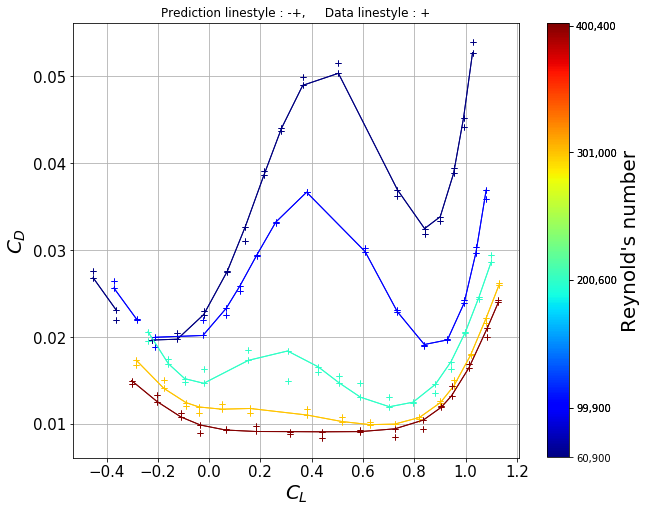

In [98]:
compare_dataframes({"Prediction": pred, "Data":e231}, ycol='Cd',ycolname='$C_D$', xcol='Cl', xcolname="$C_L$", colorbar=True, styles={"Prediction": '-+', "Data":'+'});
plt.savefig('nn_pred.png', dpi=1000)

In [101]:
CL = torch.linspace(-.5, 1.2, 100)
Re = torch.linspace(70000, 400000, 10)
inp = (torch.stack(torch.meshgrid([CL, Re]), -1).view(-1,2) - inp_mean)/inp_std
inp_data = (inp * inp_std + inp_mean).data
out_data = (model(inp) * out_std + out_mean).data
pred = pd.DataFrame.from_dict({
    "Cl":inp_data[:,0],
    "Cd":out_data[:,0],
    "Re":inp_data[:,1]
})

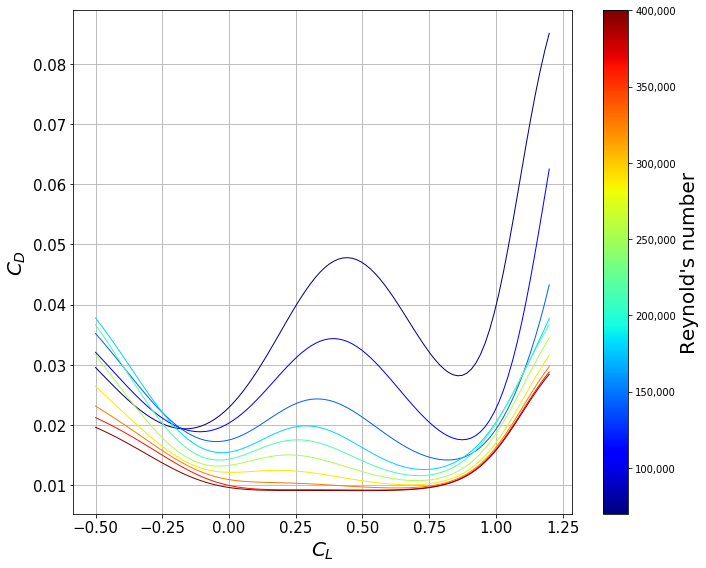

In [108]:
plot_available_data(pred, ycol='Cd', ycolname="$C_D$", xcol='Cl', xcolname='$C_L$', style='-', colorbar=True);
plt.savefig('nn.png', dpi=1000)